In [1]:
import zipfile
import os
import pandas as pd

zip_path = 'data-selected.zip'
extract_dir = 'data-selected'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("解压后的文件列表：", os.listdir(extract_dir))


for fname in os.listdir(extract_dir):
    if fname.endswith('.csv'):
        df = pd.read_csv(os.path.join(extract_dir, fname))
        print(f"读取 {fname}：行数={df.shape[0]}，列数={df.shape[1]}")

解压后的文件列表： ['los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv', 'los_angeles_censustracts.json']
读取 los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv：行数=5144062，列数=7


In [ ]:
!pip install shapely



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
# ——  Q9  —— #

import pandas as pd
import json
import networkx as nx
from shapely.geometry import shape


df = pd.read_csv('data-selected/los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv')
dec = df[df['month'] == 12].copy()

dec['sourceid'] = dec['sourceid'].astype(int).astype(str)
dec['dstid']    = dec['dstid'].astype(int).astype(str)

with open('data-selected/los_angeles_censustracts.json') as f:
    gj = json.load(f)

centroids = {}
for feat in gj['features']:
    mid = str(feat['properties']['MOVEMENT_ID'])
    centroids[mid] = shape(feat['geometry']).centroid.coords[0]


G = nx.Graph()
for mid, coord in centroids.items():
    G.add_node(mid, centroid=coord)

pairs = (
    dec
    .groupby(['sourceid', 'dstid'])['mean_travel_time']
    .mean()
    .reset_index()
)

for _, row in pairs.iterrows():
    o, d = row['sourceid'], row['dstid']
    if o != d and o in centroids and d in centroids:
        G.add_edge(o, d, weight=row['mean_travel_time'])

if G.number_of_nodes() > 0:
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()

print("Cleaned graph — nodes:", G.number_of_nodes())
print("Cleaned graph — edges:", G.number_of_edges())


Cleaned graph — nodes: 2649
Cleaned graph — edges: 1003858


In [ ]:
!pip install python-igraph



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [5]:
!brew install pkg-config cairo
!pip install cairocffi


==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> Downloading https://ghcr.io/v2/homebrew/portable-ruby/portable-ruby/blobs/sha256:fd162df7a06190ee800a9e6afd28f4466d33548821a480ba043cd927b44d60f7
######################################################################### 100.0%
==> Pouring portable-ruby-3.4.4.arm64_big_sur.bottle.tar.gz
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
addons-linter       cram                hyper-mcp           skalibs
alejandra           erlang@27           miniprot            skani
autocycler          execline            oxen                style-dictionary
aws-lc              fastga              qnm                 sylph
boa                 flip-link           readsb              webdav
bsc                 gcc@14              rna-star
concurrentqueue     gcli     

In [6]:
pip install geopy


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# —— Q10—— #

import random
import networkx as nx
from geopy.geocoders import Nominatim
from tqdm.notebook import tqdm

mst = nx.minimum_spanning_tree(G, weight='weight')
print("MST nodes:", mst.number_of_nodes(), "  MST edges:", mst.number_of_edges())

edges = list(mst.edges(data=True))
sample = random.sample(edges, 5)

geolocator = Nominatim(user_agent="la_mst_q10")
results = []
for u, v, data in tqdm(sample, desc="Reverse geocoding"):
    coord_u = (G.nodes[u]['centroid'][1], G.nodes[u]['centroid'][0])
    coord_v = (G.nodes[v]['centroid'][1], G.nodes[v]['centroid'][0])
    addr_u = geolocator.reverse(coord_u, exactly_one=True).address
    addr_v = geolocator.reverse(coord_v, exactly_one=True).address
    results.append((u, v, data['weight'], addr_u, addr_v))

for u, v, w, a_u, a_v in results:
    print(f"Edge ({u}-{v}), weight={w:.1f} min:")
    print(f"  {a_u}")
    print(f"  {a_v}\n")



MST nodes: 2649   MST edges: 2648


Reverse geocoding:   0%|          | 0/5 [00:00<?, ?it/s]

Edge (468-2294), weight=84.5 min:
  San Gabriel River Freeway, City of Industry, Los Angeles County, California, 91732, United States
  Valley View Drive, Rose Hill, Rose Hills, Los Angeles County, California, 90601, United States

Edge (28-36), weight=84.6 min:
  859, Arcadia Avenue, West Arcadia, Arcadia, Los Angeles County, California, 91007, United States
  811, West Camino Real Avenue, West Arcadia, Arcadia, Los Angeles County, California, 91007, United States

Edge (76-459), weight=33.6 min:
  Cloverleaf Drive, City of Industry, Baldwin Park, Los Angeles County, California, 91732, United States
  Smurfit Kappa Baldwin Park, Baldwin Park Boulevard, City of Industry, Los Angeles County, California, 91746, United States

Edge (838-839), weight=95.8 min:
  14816, West Carpentieri Court, Panorama City, Panorama City Neighborhood Council District, Los Angeles, Los Angeles County, California, 91402, United States
  Panorama City Elementary School, 8600, Kester Avenue, Panorama City, Pan

/var/folders/wj/nk1kp0b916v4c_nwc8d0qd_c0000gn/T/ipykernel_61304/2324092805.py:14: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  giant = g.clusters().giant()


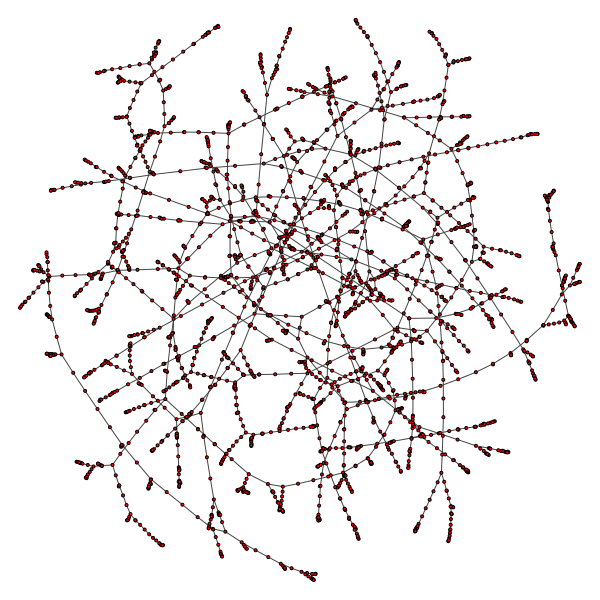

In [ ]:
import igraph as ig

tuples = [tuple(x) for x in pairs[['sourceid','dstid','mean_travel_time']].values]
g = ig.Graph.TupleList(
    tuples,
    directed=False,
    vertex_name_attr="name",
    edge_attrs=["weight"]
)

giant = g.clusters().giant()

mst = giant.spanning_tree(weights=giant.es["weight"])

out = ig.plot(mst, vertex_size=3)
out.save("Q10.png")
out


In [ ]:
import random

nodes = list(G.nodes())
nbrs = {u: set(G[u]) for u in nodes}

seen, samples = set(), []
while len(samples) < 1000:
    u = random.choice(nodes)
    if len(nbrs[u]) < 2: continue
    v, w = random.sample(list(nbrs[u]), 2)

    if w not in nbrs[v]:  
        continue
    tri = tuple(sorted((u, v, w)))
    if tri in seen:
        continue
    seen.add(tri)
    w_uv = G[u][v]['weight']
    w_uw = G[u][w]['weight']
    w_vw = G[v][w]['weight']
    samples.append((w_uv, w_uw, w_vw))


def satisfies(a, b, c):
    return (a <= b + c) and (b <= a + c) and (c <= a + b)

count = sum(1 for a, b, c in samples if satisfies(a, b, c))
prop = count / len(samples)

print(f"{count} out of 1000 sampled triangles satisfy the triangle inequality ({prop:.3%}).")


875 out of 1000 sampled triangles satisfy the triangle inequality (87.500%).


In [ ]:
import networkx as nx

mst_nx = nx.minimum_spanning_tree(G, weight='weight')

mst_weight = sum(attr['weight'] for u, v, attr in mst_nx.edges(data=True))

root = next(iter(mst_nx.nodes()))
preorder = list(nx.dfs_preorder_nodes(mst_nx, source=root)) + [root]
tour, seen = [], set()
for node in preorder:
    if node not in seen:
        tour.append(node)
        seen.add(node)
tour.append(root)

tour_cost = 0.0
for u, v in zip(tour[:-1], tour[1:]):
    if G.has_edge(u, v):
        tour_cost += G[u][v]['weight']
    else:
        tour_cost += nx.shortest_path_length(G, u, v, weight='weight')

rho = tour_cost / mst_weight

print(f"MST weight:      {mst_weight:.1f} min")
print(f"TSP tour length: {tour_cost:.1f} min")
print(f"Ratio rho =      {rho:.3f}")


MST weight:      259450.2 min
TSP tour length: 453843.8 min
Ratio rho =      1.749


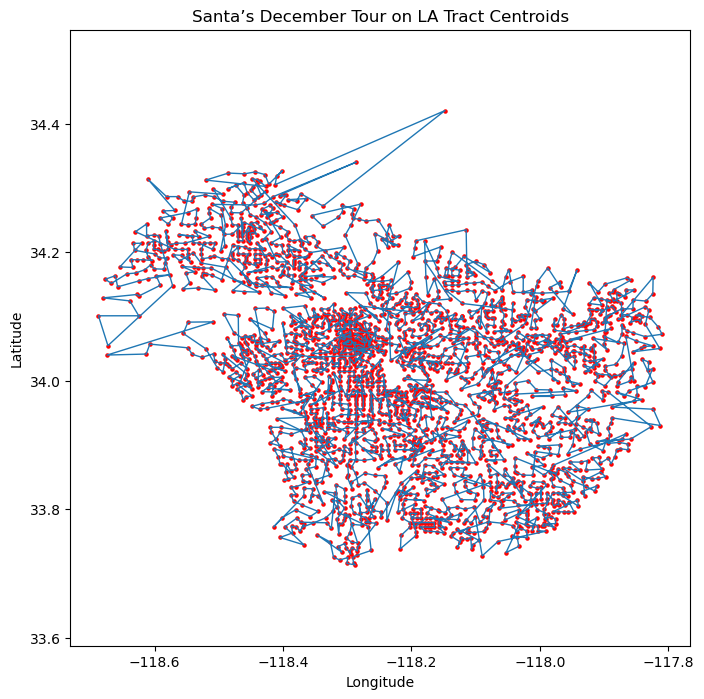

In [ ]:
import matplotlib.pyplot as plt

xs = [centroids[node][0] for node in tour]
ys = [centroids[node][1] for node in tour]

plt.figure(figsize=(8, 8))
plt.plot(xs, ys, linewidth=1)       
plt.scatter(xs, ys, s=5, color='red')  
plt.title("Santa’s December Tour on LA Tract Centroids")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis('equal')
plt.show()


In [ ]:
import folium
m = folium.Map(location=[34.05, -118.25], zoom_start=10, tiles="CartoDB positron")

for lon, lat in centroids.values():
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,
        color='red',
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

m


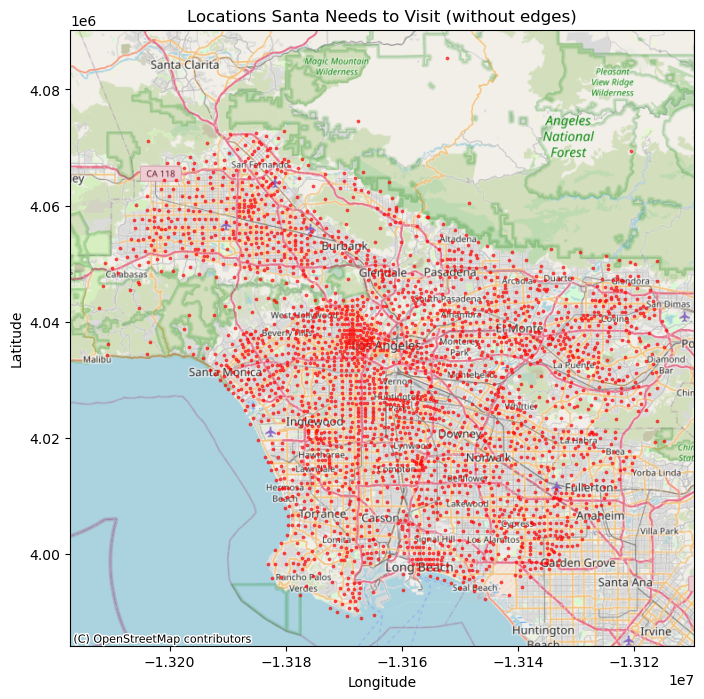

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import matplotlib.pyplot as plt


points = [Point(lon, lat) for lon, lat in centroids.values()]
gdf = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")

gdf_web = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 8))
gdf_web.plot(ax=ax, markersize=3, color='red', alpha=0.6)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Locations Santa Needs to Visit (without edges)")

plt.show()


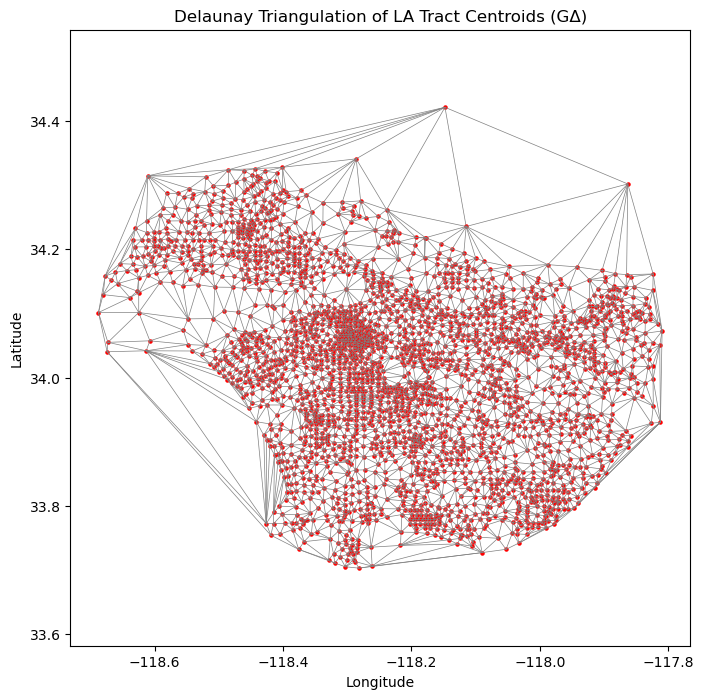

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import Delaunay

tract_ids = list(centroids.keys())
coords    = np.array([centroids[t] for t in tract_ids])  

tri = Delaunay(coords)

edge_set = set()
for simplex in tri.simplices:

    for i in range(3):
        u, v = simplex[i], simplex[(i+1) % 3]
        edge = tuple(sorted((u, v)))
        edge_set.add(edge)

GΔ = nx.Graph()

for idx, tract in enumerate(tract_ids):
    GΔ.add_node(idx, tract=tract, centroid=coords[idx])

for u, v in edge_set:
    p, q = coords[u], coords[v]
    dist = np.linalg.norm(p - q)
    GΔ.add_edge(u, v, weight=dist)

plt.figure(figsize=(8, 8))

for u, v in GΔ.edges():
    x0, y0 = GΔ.nodes[u]['centroid']
    x1, y1 = GΔ.nodes[v]['centroid']
    plt.plot([x0, x1], [y0, y1], color='gray', linewidth=0.5)

xs, ys = coords[:, 0], coords[:, 1]
plt.scatter(xs, ys, s=5, color='red')
plt.title("Delaunay Triangulation of LA Tract Centroids (GΔ)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis('equal')
plt.show()


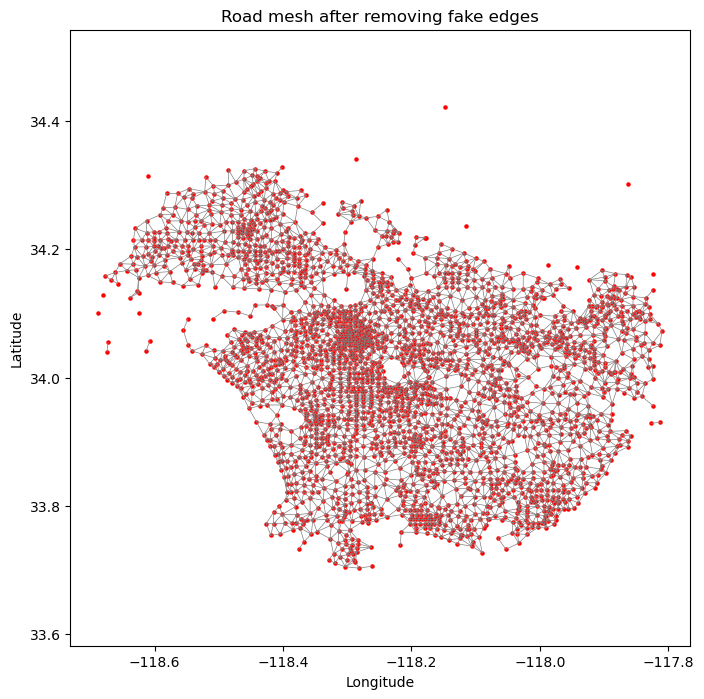

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

coords = np.array(list(centroids.values()))  

tri = Delaunay(coords)
edges = set()
for simplex in tri.simplices:
    for i in range(3):
        u, v = sorted((simplex[i], simplex[(i+1) % 3]))
        edges.add((u, v))

dists = [np.linalg.norm(coords[u] - coords[v]) for u, v in edges]
threshold = np.percentile(dists, 95)

plt.figure(figsize=(8, 8))

for u, v in edges:
    p, q = coords[u], coords[v]
    if np.linalg.norm(p - q) <= threshold:
        plt.plot([p[0], q[0]], [p[1], q[1]], color='gray', linewidth=0.5)

plt.scatter(coords[:, 0], coords[:, 1], s=5, color='red')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road mesh after removing fake edges')
plt.axis('equal')
plt.show()


In [29]:
import numpy as np

# Assumptions
ell = 5.0            # vehicle length in meters
gap = 2.0            # safe bumper gap in meters
s   = ell + gap      # minimum headway distance
L   = 2              # lanes per road
R   = 111320.0       # meters per degree latitude
phi0 = np.deg2rad(34.0)  

def edge_capacity(lon1, lat1, lon2, lat2, t_min):
    # 1. Compute planar distance (equirectangular)
    dx = (lon2 - lon1) * np.cos(phi0) * R
    dy = (lat2 - lat1) * R
    d = np.hypot(dx, dy)
    # 2. Derive free‐flow speed (m/s)
    v = d / (60.0 * t_min)
    # 3. Per‐lane flow (veh/s)
    q = v / s
    # 4. Capacity (veh/hr)
    return 3600.0 * L * q

# Example on a few edges from `pairs` and `centroids`
capacities = []
for _, row in pairs.head(5).iterrows():
    o, d_ = row['sourceid'], row['dstid']
    lon1, lat1 = centroids[o]
    lon2, lat2 = centroids[d_]
    cap = edge_capacity(lon1, lat1, lon2, lat2, row['mean_travel_time'])
    capacities.append((o, d_, cap))

# Display
for o, d_, cap in capacities:
    print(f"Edge {o}–{d_}: C = {cap:.0f} vehicles/hour")


Edge 1–10: C = 102 vehicles/hour
Edge 1–1031: C = 216 vehicles/hour
Edge 1–1032: C = 223 vehicles/hour
Edge 1–1037: C = 195 vehicles/hour
Edge 1–1041: C = 123 vehicles/hour


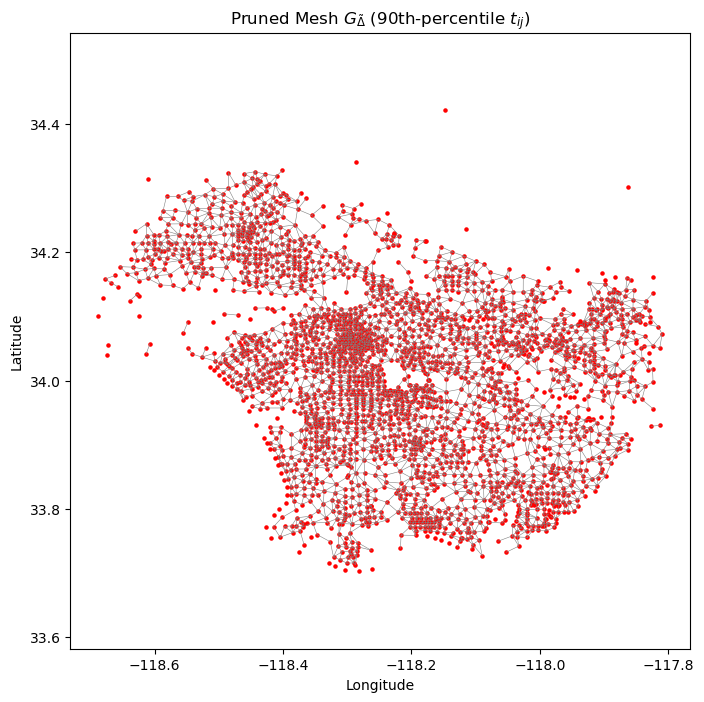

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Re-compute raw Delaunay edges (if not already in memory)
coords = np.array(list(centroids.values()))
from scipy.spatial import Delaunay
tri = Delaunay(coords)
all_edges = set()
for simplex in tri.simplices:
    for i in range(3):
        u, v = sorted((simplex[i], simplex[(i+1) % 3]))
        all_edges.add((u, v))

# 2. Remove “fake” edges by length (95th percentile)
lengths = [np.linalg.norm(coords[u] - coords[v]) for u, v in all_edges]
length_thresh = np.percentile(lengths, 95)
edges_pruned = [(u, v) for u, v in all_edges
                if np.linalg.norm(coords[u] - coords[v]) <= length_thresh]

# 3. Build a lookup for mean travel times
tt_map = {(row['sourceid'], row['dstid']): row['mean_travel_time']
          for _, row in pairs.iterrows()}
def get_tt(a, b):
    return tt_map.get((a, b), tt_map.get((b, a), np.inf))

tract_ids = list(centroids.keys())

# 4. Compute travel times for each pruned edge
travel_times = []
for u, v in edges_pruned:
    oi, dj = tract_ids[u], tract_ids[v]
    travel_times.append(get_tt(oi, dj))

# 5. Pick a travel-time threshold (e.g. 90th percentile)
time_thresh = np.percentile([t for t in travel_times if np.isfinite(t)], 90)

# 6. Further prune by travel time
edges_tt_pruned = [
    (u, v) for (u, v), t in zip(edges_pruned, travel_times)
    if t <= time_thresh
]

# 7. Plot G̃Δ
plt.figure(figsize=(8, 8))
for u, v in edges_tt_pruned:
    x0, y0 = coords[u]
    x1, y1 = coords[v]
    plt.plot([x0, x1], [y0, y1], color='gray', linewidth=0.4)
plt.scatter(coords[:, 0], coords[:, 1], s=5, color='red')
plt.axis('equal')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(r'Pruned Mesh $G_{\tilde\Delta}$ (90th‐percentile $t_{ij}$)')
plt.show()


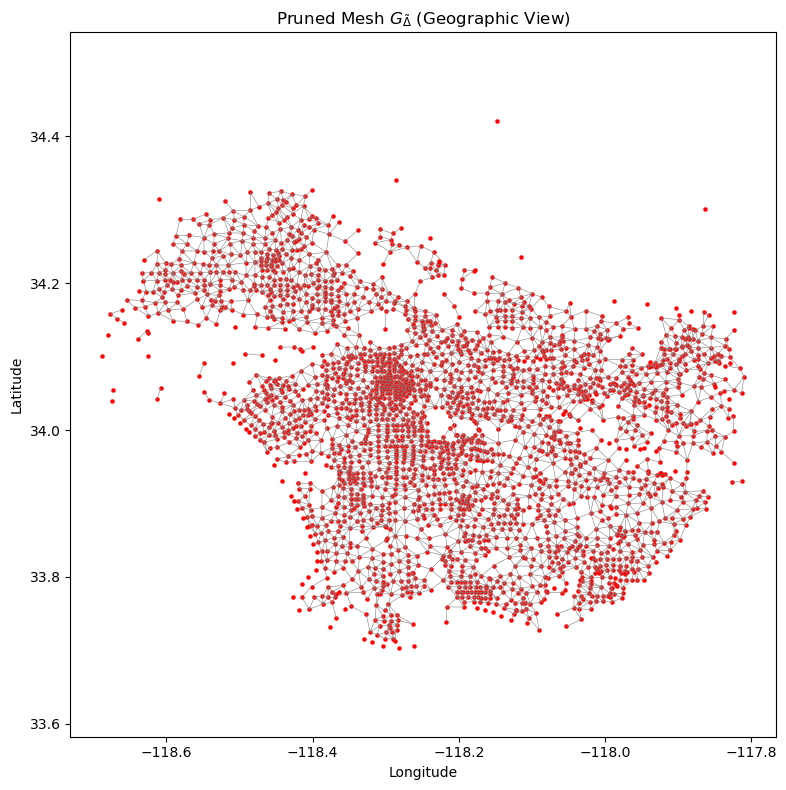

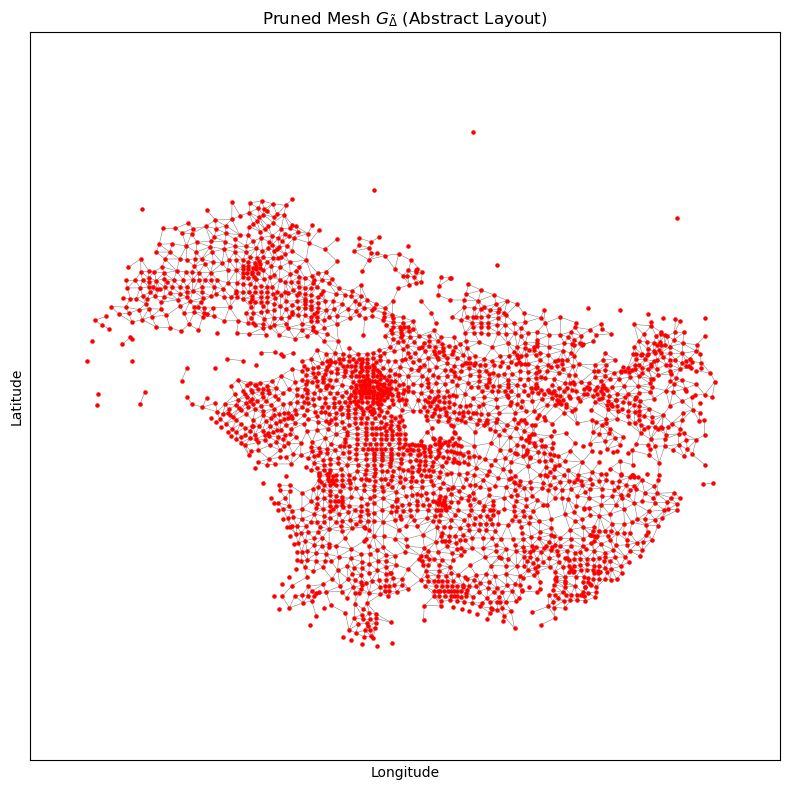

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import Delaunay

# —— 准备数据 —— #

# centroids: dict {tract_id: (lon, lat)}
tract_ids = list(centroids.keys())
coords    = np.array([centroids[t] for t in tract_ids])  # shape (N,2)

# 1) 原始 Delaunay 边
tri = Delaunay(coords)
all_edges = {(min(i,j), max(i,j))
             for simplex in tri.simplices
             for i in simplex for j in simplex if i<j}

# 2) 按长度剔除假边（95th 分位）
lengths      = [np.linalg.norm(coords[u]-coords[v]) for u,v in all_edges]
dist_thresh  = np.percentile(lengths, 95)
edges_geo    = [(u,v) for u,v in all_edges
                if np.linalg.norm(coords[u]-coords[v]) <= dist_thresh]

# 3) 按时长剔除慢速边（90th 分位）
# 构建 travel-time 查找表
tt_map = {(r['sourceid'], r['dstid']): r['mean_travel_time']
          for _,r in pairs.iterrows()}
def get_tt(a,b):
    return tt_map.get((a,b), tt_map.get((b,a), np.inf))

# 计算每条 geo 剪枝后边的 travel time
times = [get_tt(tract_ids[u], tract_ids[v]) for u,v in edges_geo]
time_thresh    = np.percentile([t for t in times if np.isfinite(t)], 90)
edges_tt_pruned = [e for e,t in zip(edges_geo, times) if t <= time_thresh]

# —— 图 1：地理叠加 —— #

plt.figure(figsize=(8,8))
# 画剪枝后的边
for u,v in edges_tt_pruned:
    x0,y0 = coords[u]
    x1,y1 = coords[v]
    plt.plot([x0,x1], [y0,y1], color='gray', linewidth=0.4)
# 画质心点
plt.scatter(coords[:,0], coords[:,1], s=5, color='red')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(r'Pruned Mesh $G_{\tilde\Delta}$ (Geographic View)')
plt.axis('equal')
plt.tight_layout()
plt.show()

# —— 图 2：抽象网络布局 —— #

# 用地理坐标直接作为 pos，以保留大致经纬形状
pos_geo = {i: coords[i] for i in range(len(coords))}
G_tt = nx.Graph()
G_tt.add_nodes_from(pos_geo.keys())
G_tt.add_edges_from(edges_tt_pruned)

plt.figure(figsize=(8,8))
nx.draw_networkx_edges(G_tt, pos_geo, edge_color='gray', width=0.4)
nx.draw_networkx_nodes(G_tt, pos_geo, node_size=5, node_color='red')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(r'Pruned Mesh $G_{\tilde\Delta}$ (Abstract Layout)')
plt.axis('equal')
plt.tight_layout()
plt.show()


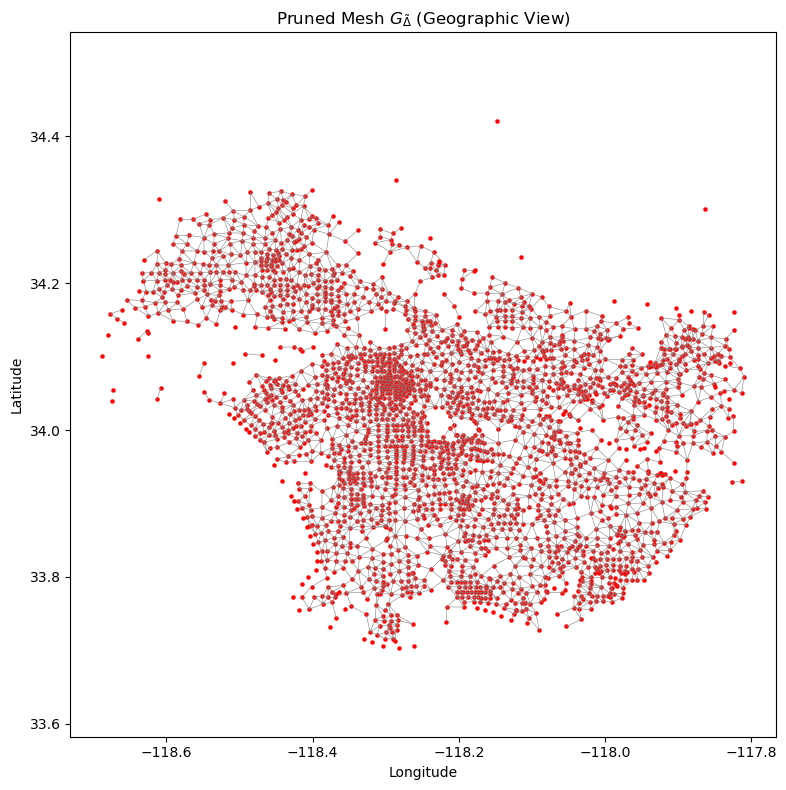

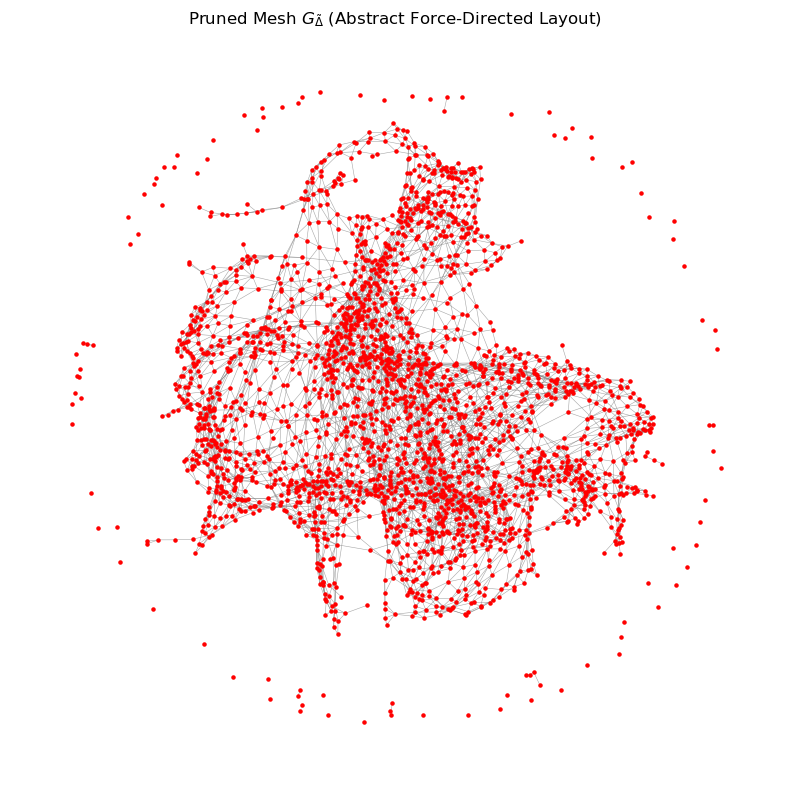

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import Delaunay

# —— 1. 重建并剪枝网格（两步：地理长度 95th，旅行时长 90th） —— #

# (a) 准备 centroid 坐标
tract_ids = list(centroids.keys())
coords    = np.array([centroids[t] for t in tract_ids])  # shape (N,2)

# (b) 原始 Delaunay 边
tri = Delaunay(coords)
all_edges = {(min(i,j), max(i,j))
             for simplex in tri.simplices
             for i in simplex for j in simplex if i<j}

# (c) 按长度剔除假边
lengths     = [np.linalg.norm(coords[u]-coords[v]) for u,v in all_edges]
dist_thresh = np.percentile(lengths, 95)
edges_geo   = [(u,v) for u,v in all_edges
               if np.linalg.norm(coords[u]-coords[v]) <= dist_thresh]

# (d) 按时长剔除慢速边
tt_map = {(r['sourceid'],r['dstid']):r['mean_travel_time']
          for _,r in pairs.iterrows()}
def get_tt(a,b):
    return tt_map.get((a,b), tt_map.get((b,a), np.inf))

times = [get_tt(tract_ids[u], tract_ids[v]) for u,v in edges_geo]
time_thresh = np.percentile([t for t in times if np.isfinite(t)], 90)
edges_pruned = [e for e,t in zip(edges_geo, times) if t <= time_thresh]

# —— 2. 地理叠加视图 —— #

plt.figure(figsize=(8,8))
for u,v in edges_pruned:
    x0,y0 = coords[u]
    x1,y1 = coords[v]
    plt.plot([x0,x1],[y0,y1], color='gray', linewidth=0.4)
plt.scatter(coords[:,0], coords[:,1], s=5, color='red')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(r'Pruned Mesh $G_{\tilde\Delta}$ (Geographic View)')
plt.axis('equal')
plt.tight_layout()
plt.show()

# —— 3. 抽象力导向布局 —— #

# 构造 NetworkX 图
G_tt = nx.Graph()
G_tt.add_nodes_from(range(len(tract_ids)))
G_tt.add_edges_from(edges_pruned)

# 使用 spring_layout（力导向）计算抽象布局
pos_spring = nx.spring_layout(G_tt, seed=42, k=0.05, iterations=100)

plt.figure(figsize=(8,8))
nx.draw_networkx_edges(G_tt, pos_spring, edge_color='gray', width=0.4, alpha=0.7)
nx.draw_networkx_nodes(G_tt, pos_spring, node_size=5, node_color='red')
plt.title('Pruned Mesh $G_{\\tilde\\Delta}$ (Abstract Force‐Directed Layout)')
plt.axis('off')
plt.tight_layout()
plt.show()


In [2]:
import networkx as nx

# assume you still have:
#   coords        = np.array(list(centroids.values()))
#   edge_set      = set of index‐pairs for all Delaunay edges
#   distances     = list of Euclidean lengths for each edge in edge_set
#   threshold     = np.percentile(distances, 95)

# build a pruned Delaunay graph
G_pruned = nx.Graph()
for (u, v), d in zip(edge_set, distances):
    if d <= threshold:
        # add both endpoints (node attributes optional)
        G_pruned.add_node(u, centroid=coords[u])
        G_pruned.add_node(v, centroid=coords[v])
        # add the pruned edge with its length
        G_pruned.add_edge(u, v, length=d)

# now you can run your Q15 capacity loop on G_pruned
L    = 5.0
ts   = 2.0
lanes= 2
deg2m=111000

for u, v, data in G_pruned.edges(data=True):
    # compute real‐world length in meters
    lon0, lat0 = G_pruned.nodes[u]['centroid']
    lon1, lat1 = G_pruned.nodes[v]['centroid']
    dx = (lon1 - lon0) * deg2m * np.cos(np.deg2rad((lat0+lat1)/2))
    dy = (lat1 - lat0) * deg2m
    length_m = np.hypot(dx, dy)

    # look up mean December travel time (in seconds) from your cleaned G
    tt = G_cleaned[u][v]['weight'] * 60.0

    # compute speed v and headway h
    v_ms = length_m / tt
    h    = ts + L / v_ms

    # compute capacity
    cap  = lanes * 3600.0 / h
    G_pruned[u][v]['capacity'] = cap


NameError: name 'edge_set' is not defined